![](https://www.gstatic.com/devrel-devsite/v2355ed73ae6b243a36832e70498f2cd0b3f352ff30481ebdfdc56826b566bf8a/tensorflow/images/lockup.svg)

До сегодняшнего дня мы собирали различные довольно простые модели в высокоуровневом API для [tensorflow](https://www.tensorflow.org/) под названием Keras. Сегодня, наконец, пришло время поиграться с голым ~~королём~~ функционалом библиотеки и посмотреть, как в нём собираются и обучаются самые простые модели. 

In [1]:
import numpy as np

In [2]:
import tensorflow as tf
tf.__version__  # ОУУУУ ЩИИИИТ, ВТОРАЯ ВЕРСИЯ!!! АААААААААААА

'2.1.0'

# 0. Tensoflow teaser

Давайте реализуем на `numpy` и на `tensorflow` функцию для поиска суммы квадратов первых $N$ чисел и посмотрим насколько быстро эти функции работают.

In [3]:
def np_sum_squares(N):
    return np.sum(np.arange(N)**2)

In [4]:
%%timeit
N = 10**8
np_sum_squares(N)

482 ms ± 24.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Tensorflow из-за того, что мы сначала задаём структуру вычислений, а после осуществляем их. Работает медленнее, чем numpy.

In [5]:
def tf_sum_squares(N):
    N = tf.constant(N, dtype='int64')
    return tf.reduce_sum((tf.range(N)**2))

In [6]:
%%timeit
N = 10**8
tf_sum_squares(N)

623 ms ± 31.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Более того, когда вы уже задали свой граф вычислений и убедились, что всё работает, можно вызвать декоратор `tf.function`. [Он сделает работу заданного графа](https://www.tensorflow.org/tutorials/customization/performance) более оптимальной и ещё ускорит код. 

In [7]:
@tf.function
def tf_sum_squares(N):
    N = tf.constant(N, dtype='int64')
    return tf.reduce_sum((tf.range(N)**2))

In [8]:
%%timeit
N = 10**8
tf_sum_squares(N)

228 ms ± 8.34 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Если сравнивать время, то мы видим значительный прогресс в скорости вычислений даже для простой задачи. Данный прирост будет значительно большим для сложных и тяжелых по памяти рассчетов.

# 1. Тензоры и базовые операции над ними

Основной объект в tensorflow - это **тензор.** Или многомерный массив чисел. Чтобы не нужно было учить кучу новых команд, tensorflow косплеит numpy. 

```
    np.zeros -> tf.zeros
    np.sin -> tf.sin
    np.mean -> tf.reduce_mean
    np.arange -> tf.range
    np.cumsum -> tf.cumsum
```

Правда говоря, не совсем косплеит. Но чаще всего оказываетс довольно близок.

In [9]:
# можно задать тензор из нулей
tf.zeros([3, 4])

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]], dtype=float32)>

In [10]:
# или из единиц, но уже более сложной размерности
tf.ones([3, 4, 2])

<tf.Tensor: shape=(3, 4, 2), dtype=float32, numpy=
array([[[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.]],

       [[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.]],

       [[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.]]], dtype=float32)>

In [11]:
# можно сгенерировать тензор из нормального распределения
tf.random.normal([2,2])

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[ 0.4462439 , -0.6712033 ],
       [ 1.1283394 ,  0.52256143]], dtype=float32)>

In [12]:
# можно просто сделать залифку тензора какими-то числами
tf.fill([2, 2], 0.5)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.5, 0.5],
       [0.5, 0.5]], dtype=float32)>

In [13]:
# можно создать матрицу в numpy
x = np.array([[1, 2, 3, 4],
              [4, 3, 2, 1]])
x

array([[1, 2, 3, 4],
       [4, 3, 2, 1]])

In [14]:
# а потом перевести её в тензор
tf.convert_to_tensor(x, tf.float32) 

<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[1., 2., 3., 4.],
       [4., 3., 2., 1.]], dtype=float32)>

In [15]:
# или можно просто сразу создать тензор 
tf.constant([[1,  2,  3,  4],
             [5,  6,  7,  8],
             [9, 10, 11, 12]])

<tf.Tensor: shape=(3, 4), dtype=int32, numpy=
array([[ 1,  2,  3,  4],
       [ 5,  6,  7,  8],
       [ 9, 10, 11, 12]])>

In [22]:
# наверное, стоит уточнить тип данных в тензоре
x = tf.constant([[1,  2,  3,  4],
                 [5,  6,  7,  8],
                 [9, 10, 11, 12]], dtype=tf.float32)

Все срезы, операции, размерности работают как в numpy.

In [23]:
x.dtype

tf.float32

In [24]:
x.shape

TensorShape([3, 4])

In [25]:
x[0]

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([1., 2., 3., 4.], dtype=float32)>

In [26]:
x[:,1]

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([ 2.,  6., 10.], dtype=float32)>

In [35]:
%%timeit
x + 10

221 µs ± 25.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [36]:
%%timeit
x + tf.constant(10.)

195 µs ± 12.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [28]:
x[x > 3]

<tf.Tensor: shape=(9,), dtype=float32, numpy=array([ 4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.], dtype=float32)>

In [29]:
y = tf.constant([[12, 11, 10, 9],
                  [8, 7, 6, 5],
                  [4, 3, 2, 1]], dtype=tf.float32)

In [30]:
x + y

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[13., 13., 13., 13.],
       [13., 13., 13., 13.],
       [13., 13., 13., 13.]], dtype=float32)>

In [31]:
x**y

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[1.0000000e+00, 2.0480000e+03, 5.9049000e+04, 2.6214398e+05],
       [3.9062500e+05, 2.7993600e+05, 1.1764901e+05, 3.2768000e+04],
       [6.5610005e+03, 9.9999994e+02, 1.2100000e+02, 1.2000000e+01]],
      dtype=float32)>

In [32]:
tf.math.exp(x)

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[2.7182817e+00, 7.3890562e+00, 2.0085537e+01, 5.4598148e+01],
       [1.4841316e+02, 4.0342880e+02, 1.0966332e+03, 2.9809580e+03],
       [8.1030840e+03, 2.2026467e+04, 5.9874141e+04, 1.6275480e+05]],
      dtype=float32)>

In [33]:
# Когда надоело работать с тензором, можно вернуться назад в numpy формат
x.numpy() 

array([[ 1.,  2.,  3.,  4.],
       [ 5.,  6.,  7.,  8.],
       [ 9., 10., 11., 12.]], dtype=float32)

In [34]:
# тип у тензоров может быть разный, но всегда один
tf.constant("hello world")

<tf.Tensor: shape=(), dtype=string, numpy=b'hello world'>

### Задание 1:

Попробуйте реализовать на tensorflow сигмоиду. 

$$ \sigma(x) = \frac{1}{1 + e^{-x}} $$

In [41]:
# Ваше решение
x = tf.linspace(-1.,1.,10)
sigmoid = 1./(1+tf.exp(-x))

In [42]:
sigmoid

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.26894143, 0.314799  , 0.36457646, 0.41742983, 0.4722508 ,
       0.52774924, 0.5825702 , 0.6354236 , 0.685201  , 0.7310586 ],
      dtype=float32)>

### Задание 2:

Попробуйте реализовать на tensorflow среднюю квадратичную ошибку. 

$$ 
MSE(\hat y, y) = \sum_{i=1}^n (\hat y - y)^2
$$

In [45]:
# Ваше решение
y_true = tf.constant([1.,2.,3.,4.,5.],tf.float32)
y_pred = tf.constant([10.,20.,30.,40.,50.],tf.float32)
diff = y_true-y_pred
mse = tf.reduce_mean(tf.pow(diff,2))

In [47]:
tf.reduce_mean((y_true-y_pred)**2)

<tf.Tensor: shape=(), dtype=float32, numpy=891.0>

------------------------------------------

# 2. Производные да градиенты

Тензорфлоу может вычислять производные и градиенты автоматически. Для этого используется [`GradientTape.`](https://www.tensorflow.org/tutorials/customization/autodiff)

Он проходит по всем операциям, которые фигурируют в графе, и применяет к ним chain rule:

$$ {\partial f(g(x)) \over \partial x} = {\partial f(g(x)) \over \partial g(x)}\cdot {\partial g(x) \over \partial x} $$

Мы можем посчитать производную по любому тензору, участвующему в вычислениях.

In [52]:
tf.random.normal([2,2,3,2])

<tf.Tensor: shape=(2, 2, 3, 2), dtype=float32, numpy=
array([[[[-0.09354337, -0.66495365],
         [-0.6166549 ,  0.38046435],
         [ 1.2729412 ,  0.18566397]],

        [[ 0.8971223 , -1.2371137 ],
         [-1.6187551 ,  0.64792144],
         [-0.55547047,  0.6806206 ]]],


       [[[-0.5430494 , -0.22897829],
         [-0.07899652,  0.5418916 ],
         [ 1.2954999 ,  0.4508586 ]],

        [[-0.346505  ,  0.07215521],
         [-0.361138  , -0.6924847 ],
         [-0.48946628, -1.592958  ]]]], dtype=float32)>

In [53]:
x = tf.constant([0.3, 1])

# опция persistent=True позволяет искать производную много раз, а не один
with tf.GradientTape(persistent=True) as t:
    t.watch(x)
    y = tf.reduce_sum(x,axis=0)
    z = y**2

In [49]:
t.gradient(z, x)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([2.6, 2.6], dtype=float32)>

In [50]:
t.gradient(z, y)

<tf.Tensor: shape=(), dtype=float32, numpy=2.6>

Нарисуем функцию и её производную на картинке :) 

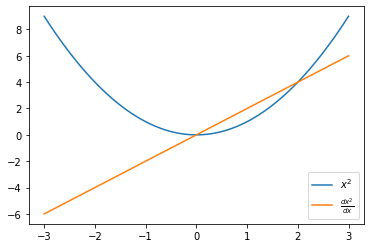

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline

x = tf.linspace(-3., 3., 100)

with tf.GradientTape(persistent=True) as t:
    t.watch(x)
    y = x**2

dy_dx = t.gradient(y, x)

plt.plot(x, y, label="$x^2$")
plt.plot(x, dy_dx, label=r"$\frac{dx^2}{dx}$")
plt.legend();

### Задание 3:

Реализуйте расчёт градиента для функции 

$$
f(w) = \prod_{i,j} \ln(\ln(w_{ij} + 7) 
$$

в точке `w = [[5,10], [1,2]]`

In [57]:
w = tf.constant([[5,10], [1,2]], dtype=tf.float32)

with tf.GradientTape() as t:
    t.watch(w)
    f = tf.reduce_prod(tf.math.log(tf.math.log(w+tf.constant(7.,tf.float32))))
# Ваше решение
df_dw = t.gradient(f,w)

Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


In [59]:
w

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[ 5., 10.],
       [ 1.,  2.]], dtype=float32)>

In [58]:
df_dw

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.0201272 , 0.01089125],
       [0.04485611, 0.03509369]], dtype=float32)>

# 3. Переменные

Следущий важный объект в tensorflow это **переменная.** Она представляет из себя некоторый буфер в памяти, который содержит текущие тензоры. 

* Переменную можно вставить в любое место графа 
* Переменные можно использовать, чтобы описать какую-то трансформацию
* В процессе расчётов их можно изменять
* Обычно их исползуют для описания параметров модели

In [60]:
w = tf.Variable(initial_value=0.5)
w

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.5>

In [61]:
x = np.array([1,2,3], dtype=float)
x

array([1., 2., 3.])

In [62]:
x*w

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.5, 1. , 1.5], dtype=float32)>

Более того, переменные хороши тем, что Tensorflow сразу же следит за ними при вычислении производных. Ему не надо указывать с помощью команды `watch`, за каким тензором нужно приглядывать. 

### Задание 4:

Реализуйте расчёт градиента для функции 

$$
f(w) = \prod_{i,j} \ln(\ln(w_{ij} + 7) 
$$

в точке `w = [[5,10], [1,2]]`. Отличие от предыдущей задачки такое: надо задать $w$ не как тензор, а как переменную. 

In [63]:
w = tf.Variable(initial_value=[[5.,10], [1,2]])
with tf.GradientTape() as t:
    f = tf.reduce_prod(tf.math.log(tf.math.log(w+tf.constant(7.,tf.float32))))
# Ваше решение
df_dw = t.gradient(f,w)

# Ваше решение

In [65]:
df_dw

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.0201272 , 0.01089125],
       [0.04485611, 0.03509369]], dtype=float32)>

------------------------------------------

# 4. Оптимизация

Итак, tf умеет искать производные, осталось научиться применять его для оптимизации. 

Попробуем решить глупую задачку по конвертации градусов по цельсию в градусы по фаренгейту. По данным будем пытаться восстановить формулу: 

$$ f = c \times 1.8 + 32 $$

In [27]:
celsius    = np.array([-40, -10,  0,  8, 15, 22,  38],  dtype='float32')
fahrenheit = np.array([-40,  14, 32, 46.4, 59, 71.6, 100.4],  dtype='float32')

for i,c in enumerate(celsius):
    print("{} degrees Celsius = {} degrees Fahrenheit".format(c, fahrenheit[i]))

-40.0 degrees Celsius = -40.0 degrees Fahrenheit
-10.0 degrees Celsius = 14.0 degrees Fahrenheit
0.0 degrees Celsius = 32.0 degrees Fahrenheit
8.0 degrees Celsius = 46.0 degrees Fahrenheit
15.0 degrees Celsius = 59.0 degrees Fahrenheit
22.0 degrees Celsius = 72.0 degrees Fahrenheit
38.0 degrees Celsius = 100.0 degrees Fahrenheit


In [29]:
[1.8*x+32 for x in celsius]

[-40.0, 14.0, 32.0, 46.4, 59.0, 71.6, 100.4]

In [67]:
# параметры модели 
a = tf.Variable(tf.random.normal([1]), name='bias')
b = tf.Variable(tf.random.normal([1]), name='k')

a.numpy(), b.numpy()

(array([-0.22475177], dtype=float32), array([1.0712941], dtype=float32))

In [68]:
# Наша модель
def linear_regression(x):
    return a + b*x

# Ошибка для модели
def mean_square(y_pred, y_true):
    return tf.reduce_mean((y_pred-y_true)**2)

In [69]:
linear_regression(celsius).numpy()

array([-43.07651   , -10.937692  ,  -0.22475177,   8.345601  ,
        15.844659  ,  23.343718  ,  40.484425  ], dtype=float32)

In [70]:
mean_square(linear_regression(celsius), fahrenheit).numpy()

1551.3661

In [72]:
# оптимизатор 
optimizer = tf.optimizers.SGD(learning_rate=0.001)

# процесс оптимизации
def model_train(X, Y):

    # находим loss и пробрасываем градиент
    with tf.GradientTape() as g:
        pred = linear_regression(X)
        loss = mean_square(pred, Y)

    # Вычисляем градиенты
    gradients = g.gradient(loss, [a, b])
    
    # Обновляем веса a и b в ходе одной итерации спуска 
    optimizer.apply_gradients(zip(gradients, [a, b]))

In [83]:
list(zip(gradients, [a, b]))

NameError: name 'gradients' is not defined

In [73]:
a

<tf.Variable 'bias:0' shape=(1,) dtype=float32, numpy=array([-0.22475177], dtype=float32)>

In [74]:
model_train(celsius, fahrenheit)

In [75]:
a

<tf.Variable 'bias:0' shape=(1,) dtype=float32, numpy=array([-0.1535459], dtype=float32)>

In [76]:
# Обучение
epochs = 2000 # число эпох 

for i in range(epochs):
    
    # Делаем щаг градиентного спуска 
    model_train(celsius, fahrenheit)
    
    # Каждую сотую итерацию следим за тем, что произошло
    if i%100 == 0:
        y_pred = linear_regression(celsius)
        loss_val = mean_square(y_pred, fahrenheit)
        print("step: %i, loss: %f, a: %f, b: %f" % (i, loss_val, a.numpy(), b.numpy()))

step: 0, loss: 986.298706, a: -0.093011, b: 2.054202
step: 100, loss: 671.436951, a: 5.511241, b: 2.021095
step: 200, loss: 457.148926, a: 10.135315, b: 1.982071
step: 300, loss: 311.257050, a: 13.950726, b: 1.949872
step: 400, loss: 211.930496, a: 17.098900, b: 1.923303
step: 500, loss: 144.307053, a: 19.696512, b: 1.901381
step: 600, loss: 98.267387, a: 21.839859, b: 1.883293
step: 700, loss: 66.922722, a: 23.608368, b: 1.868368
step: 800, loss: 45.582520, a: 25.067604, b: 1.856053
step: 900, loss: 31.053690, a: 26.271645, b: 1.845892
step: 1000, loss: 21.162104, a: 27.265127, b: 1.837507
step: 1100, loss: 14.427779, a: 28.084858, b: 1.830589
step: 1200, loss: 9.842870, a: 28.761238, b: 1.824881
step: 1300, loss: 6.721359, a: 29.319334, b: 1.820171
step: 1400, loss: 4.596169, a: 29.779829, b: 1.816285
step: 1500, loss: 3.149290, a: 30.159794, b: 1.813079
step: 1600, loss: 2.164218, a: 30.473312, b: 1.810433
step: 1700, loss: 1.493577, a: 30.731995, b: 1.808250
step: 1800, loss: 1.036

Можно сделать то же самое, но с визуализацией. 

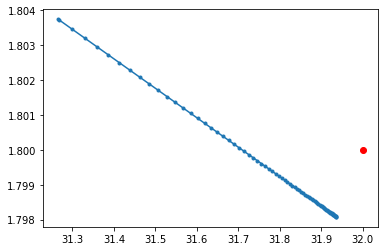

In [77]:
from IPython.display import clear_output

epochs = 2000 # число эпох 

ass = [a.numpy()[0]] # стартовые точки 
bss = [b.numpy()[0]] 

for i in range(epochs):
    # Делаем щаг градиентного спуска 
    model_train(celsius, fahrenheit)
    
    if i%25 == 0:
        # Пополняем запас точек 
        ass.append(a.numpy()[0])
        bss.append(b.numpy()[0])

        clear_output(True) # чтобы всё на одной картинке рисовалось, а не на милионе
        plt.plot(ass, bss, marker='.')
        plt.scatter(32, 1.8, c='red')
        plt.show()

### Задание 5:

Реализуйте для функции 

$$
f(w) = \prod_{i,j} \ln(\ln(w_{ij} + 7) 
$$

процедуру градиентного спуска. Каким получилось минимальное значение? 

In [78]:
w = tf.Variable(initial_value = tf.random.normal([2,2]))
for _ in range(10):
    optim = tf.optimizers.SGD(0.001)
    with tf.GradientTape() as g:
        f = tf.reduce_prod(tf.math.log(tf.math.log(w+tf.constant(7.,tf.float32))))
    # Ваше решение
    grad = g.gradient(f,[w])
    optim.apply_gradients(zip(grad,[w]))
    f_new = tf.reduce_prod(tf.math.log(tf.math.log(w+tf.constant(7.,tf.float32))))
    print(f'значение функции {f_new}')


значение функции 0.17760814726352692
значение функции 0.17760559916496277
значение функции 0.177603080868721
значение функции 0.17760048806667328
значение функции 0.17759796977043152
значение функции 0.17759539186954498
значение функции 0.17759282886981964
значение функции 0.1775902956724167
значение функции 0.17758770287036896
значение функции 0.177585169672966


In [79]:
grad

[<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[0.04038476, 0.01162323],
        [0.02315496, 0.01578118]], dtype=float32)>]

------------------------------------------

Можно попробовать поразвлекаться с разными методами оптимизации! 

* На вход модели при обучении мы сейчас подавали нумпаевские вектора. В будущем мы будем смотреть и на разные другие способы скармливать модели данные.

# 5. Нейронка на Tensorflow 

Пришло время страдать. Чтобы пострадать как следует, вы получаете задание --- построить свою первую нейросеть в tensorflow. __Спойлер:__ cильнее вего вы будете страдать от того, что размерности матриц не сходятся. Осторожнее с этим. 

Раньше все учили свою первую нейросеть на [наборе рукопистных цифр MNIST.](http://yann.lecun.com/exdb/mnist/) Теперь это не модно. Если где-то кто-то будет проводить у вас семинар с участием этого датасета, так и скажите ему: __это не модно!__  Хлопать дверью или нет --- на ваше усмотрение. 

На арене туториалов новый король: [Fashion MNIST.](https://www.tensorflow.org/tutorials/keras/classification) По ссылке лежит туториал с строительством нейросетки на этом наборе, но с участием Keras. Мы пока что обойдёмся без него.

In [1]:
import tensorflow as tf
fashion_mnist = tf.keras.datasets.fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [2]:
X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Нарисуем несколько рандомных картинок из тренировочной выборки. 

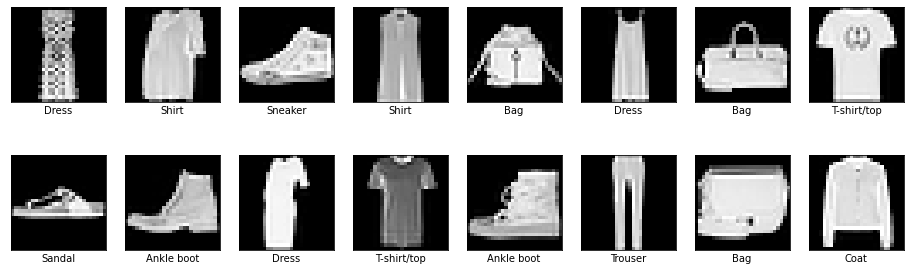

In [87]:
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols, 2.5 * rows))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(X_train[random_index, :], cmap = 'gray')
        ax.set_xlabel(class_names[y_train[random_index]])
plt.show()

Каждая картинка это матрица из чисел. Если число большое - пиксель яркий. Если маленькое - тёмный. Яркость измеряется по шкале от $0$ до $255$.

In [ ]:
X_train

Картинка - матрица. 

Давайте отнормируем выборку. 

In [4]:
X_train = X_train/255
X_test = X_test/255

Будем прогнозировать тип картинки по её пикселям. Давайте растянем её в вектор из $28 \times 28$ фичей.

In [5]:
X_train = X_train.reshape(X_train.shape[0], 28**2)
X_test = X_test.reshape(X_test.shape[0], 28**2)
X_train.shape

(60000, 784)

Поставим для данных тип, чтобы ничего не поломалось.

In [7]:
import numpy as np
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

У нас в задаче фигурирует $10$ классов. Последним слоем в сетке будет Softmax. Не забудьте сделать OHE, когда будете описывать функцию потерь. 

In [126]:
tf.keras.utils.to_categorical(y_train)

array([[0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [8]:
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

## Задание 6

Для начала обучим однослойною модель. Задайте её архитектуру и напишите функцию для прогнозирования. 

In [9]:
num_classes = 10   # число классов
num_features = 784 # число фичей (28*28 пикселей)

W = tf.Variable(tf.random.normal([num_features,num_classes]),tf.float32)
b = tf.Variable(tf.random.normal([num_classes]),tf.float32)

# Задайте переменные W и b :) 

# прогнозы
def logistic_regression(X):
    # ваша модель
    lin_prod = tf.matmul(X,W)+b
    return tf.nn.softmax(lin_prod)

In [104]:
X_train[:3].dtype

dtype('float64')

In [117]:
p_pred = logistic_regression(X_train[:3])
p_pred

<tf.Tensor: shape=(3, 10), dtype=float32, numpy=
array([[4.0187061e-04, 6.7921846e-06, 9.1156571e-06, 3.7073578e-09,
        8.8337459e-02, 8.9236355e-01, 7.1169675e-06, 3.1011367e-09,
        1.8069094e-02, 8.0505497e-04],
       [3.6765472e-04, 3.0369794e-08, 1.7682610e-04, 4.9251847e-10,
        9.9945551e-01, 9.4867589e-09, 4.8724238e-09, 2.7483982e-10,
        8.3690236e-19, 6.4106415e-10],
       [4.8545431e-03, 1.3262832e-04, 1.4195201e-03, 9.5510157e-03,
        1.7699768e-01, 8.2654716e-04, 6.2348547e-05, 8.0597508e-01,
        1.9668165e-05, 1.6095667e-04]], dtype=float32)>

Отлично! Теперь давайте реализуем функцию потерь. Использовать будем logloss. Ещё не забыли как его искать? 

In [10]:
def logloss(p_pred, y_true):
    # Чтобы не возникло log(0) и бесконечностей
    p_pred = tf.clip_by_value(p_pred, 1e-9, 1.)
    # а теперь считаем
    return -tf.reduce_mean(tf.reduce_sum(y_true * tf.math.log(p_pred), axis=1)) 

Чтобы избежать проблем с бесконечностями, обычно logloss считают по-другому, с помощью функции tf.nn.softmax_cross_entropy_with_logits. Откуда берутся проблемы в виде бесконечностей в softmax либо посмотрите во второй лекции, либо в Николенко на страницах  133−135.

In [130]:
p_pred = logistic_regression(X_train)
logloss(p_pred, y_train)

<tf.Tensor: shape=(), dtype=float32, numpy=10.800415>

На каждой итерации будем искать accuracy. Напишите функцию, чтобы его искать. 

In [19]:
def accuracy(y_pred, y_true):
    correct_pred = tf.equal(tf.argmax(y_pred,axis=1),tf.argmax(y_true,axis=1))
    # Ваша реализация точности
    
    return tf.reduce_mean(tf.cast(correct_pred,tf.float32))

In [145]:
accuracy(p_pred, y_train)

<tf.Tensor: shape=(), dtype=float32, numpy=0.087416664>

Задаём оптимизатор

In [12]:
learning_rate = 1e-4
optimizer = tf.optimizers.Adam(learning_rate)

Задаём один шаг обучения

In [13]:
@tf.function
def model_train(X, Y):
    with tf.GradientTape() as g:
        pred = logistic_regression(X)
        loss = logloss(pred,Y)
    gradients = g.gradient(loss,[W,b])

# Считаем градиенты
    
    # Обновляем веса a и b в ходе одной итерации спуска 
    optimizer.apply_gradients(zip(gradients, [W, b]))

In [150]:
b

<tf.Variable 'Variable:0' shape=(10,) dtype=float32, numpy=
array([-1.1563733 , -1.1738833 , -1.0521016 ,  0.04282658, -0.75907576,
       -2.9269009 , -0.27877045,  1.5761793 , -1.0105218 , -0.45534277],
      dtype=float32)>

In [151]:
# Работает ли?
model_train(X_train, y_train)

In [152]:
b

<tf.Variable 'Variable:0' shape=(10,) dtype=float32, numpy=
array([-1.2563719 , -1.0738845 , -1.152086  ,  0.14282589, -0.85907716,
       -2.8269038 , -0.37848088,  1.6761727 , -1.1105047 , -0.35534522],
      dtype=float32)>

Остался только этап для обучения модели. Напишем функцию, которая будет генерировать из наших данных батчи. Одна эпоха - один проход модели по всем батчам. Один батч - совокупность наблюдений.  В этом может помочь [специальный класс для создания батчей, Dataset.](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)

In [14]:
# создали объект с данными для обучения 
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))

# перемешали данные с окном в 5000 и сделали кучу батчей размера 512 
train_data = train_data.shuffle(5000).batch(512)

Напишем небольшую функцию для визуализации процедуры обучения. 

In [15]:
from IPython import display
import matplotlib.pyplot as plt
def visualize(l1,l2, h1, h2):
    plt.figure(figsize=(20,5)) 
    epo_range = range(1,len(h1)+1)
    tick_range = range(1,len(h1)+1,2)
    plt.subplot(1,2,1)
    plt.title('Learning loss')
    plt.plot(epo_range,l1, label='train set')
    plt.plot(epo_range,l2, label='valid set')
    plt.grid()
    plt.xticks(tick_range)
    plt.legend(title = 'Loss at:')
    
    plt.subplot(1,2,2)
    plt.title('Learning accuracy')
    plt.plot(epo_range,h1, label='train set')
    plt.plot(epo_range,h2, label='valid set')
    plt.grid()
    plt.xticks(tick_range)
    plt.ylim(0, 1.)
    plt.legend(title = 'Accuracy at:')
    
    display.clear_output(wait=True)
    plt.show()

Обучаем модель! 

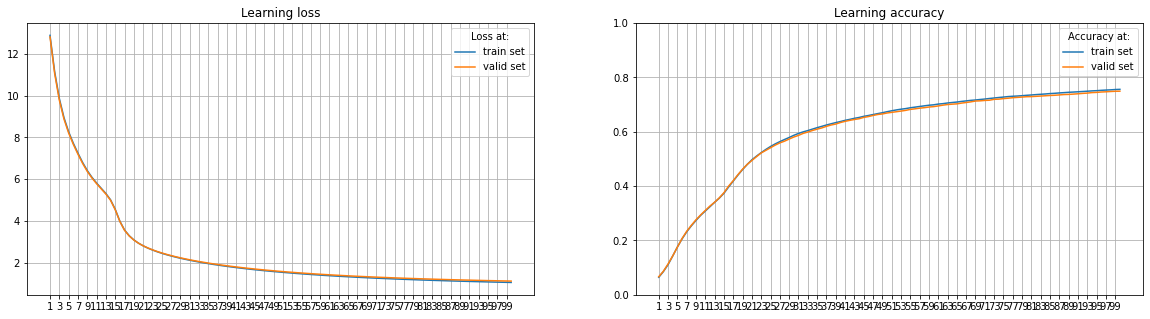

In [20]:
epochs = 100           # число эпох 
training_steps = 1000  # сколько раз на эпохе теребить генератор батчей

# Вектора для метрик
loss_test, loss_train  = [ ], [ ] 
acc_test, acc_train = [ ], [ ]

for i in range(epochs):
    
    # Проходимся по всем батчам
    for batch_x, batch_y in train_data.take(training_steps):
        model_train(batch_x,batch_y)
        
        # Делаем щаг градиентного спуска 
        ### Ваш код для шага на текущем батче

        ########################
    
    # в конце эпохи считаем метрики
    p_train = logistic_regression(X_train)
    p_test = logistic_regression(X_test)
    
    loss_train.append(logloss(p_train, y_train))
    loss_test.append(logloss(p_test, y_test))
    
    acc_train.append(accuracy(p_train, y_train))
    acc_test.append(accuracy(p_test, y_test))
    
    # визуализируем
    visualize(loss_train, loss_test, acc_train, acc_test) 

Делать такие визуализации для больших нейронок и большого количества эпох не лучшая идея, но так как мы только учимся и хотим красивых картинок, то мы можем себе это позволить. __Отдельно обратите внимание,__ что TensorFlow очень чуствительна к размерностям. Например, чтобы работала функция `matmul`, нужно подать ей на вход обязательно матрицы. Даже если это матрица размера $1 \times 1$.

## Задание 7

Переделайте свою логистическую регрессию в двухслойную нейросетку. В качестве функции активации возьмите что угодно. Функцию, где будет реализована модель назовите `our_nn`.

In [ ]:
# Ваш код


Обучаем модель!

In [ ]:
epochs = 100           # число эпох 
training_steps = 1000  # сколько раз на эпохе теребить генератор батчей

# Вектора для метрик
loss_test, loss_train  = [ ], [ ] 
acc_test, acc_train = [ ], [ ]

for i in range(epochs):
    
    # Проходимся по всем батчам
    for batch_x, batch_y in train_data.take(training_steps):
        
        # Делаем щаг градиентного спуска 
        model_train(batch_x, batch_y)
    
    p_train = our_nn(X_train)
    p_test = our_nn(X_test)
    
    loss_train.append(logloss(p_train, y_train))
    loss_test.append(logloss(p_test, y_test))
    
    acc_train.append(accuracy(p_train, y_train))
    acc_test.append(accuracy(p_test, y_test))
    
    # визуализируем
    visualize(loss_train, loss_test, acc_train, acc_test) 

# Вместо итога.

__Но... Но... Но... Намного проще собрать это в Keras! Зачем нам страдать?__

Дело в том, что Keras лишь надстройка над tensorflow. По факту все слои, написанные для Keras - это замаскированный tensorflow. Более того, даже сетку, написанную на Keras можно обучать таким вот незатейливым циклом, как у нас. Иногда так намного проще проверять свои идеи. 

* Например, в прошлый раз мы с вами пытались мень скорость обучения сетки с помощью колбэков прямо в процессе обучения. Это было довольно неприятно и код был неочевидным. Если описывать процедуру обучения в виде цикла, работать становится проще.  В Tensorflow проще делать довольно много разных вещей, а также проще реализовывать и проверять какие-то свои идеи. 
* В том числе на Tensorflow можно писать новые слои для Keras и встраивать их в свои сетки. Этим мы тоже с вами позанимаемся.

# N+1. Как Tensorflow работал раньше 

Больше такой код не надо писать никогда и нигде. Если видите его в туториалах в интернете, сразу закрывайте их. Эти туториалы устарели. Можете попробовать подуть на них (сдуть слой пыли), а дальше попробовать самостоятельно переписать старый код на новый. Это неплохое упражнение :) 

In [21]:
import tensorflow.compat.v1 as tf  # подгружаем первую версию библиотеки 
tf.disable_v2_behavior()           # отключаем функционал второй 
                                   # теперь код, написанный на версии tf 1.x должен работать 
tf.__version__

Instructions for updating:
non-resource variables are not supported in the long term


'2.1.0'

Раньше сначала надо было задать структуру вычислений с помощью тензоров. 

In [22]:
# что происходило в первой версии 
a = tf.constant([1, 2])
b = tf.constant([3, 4])

print(a + b)

Tensor("add:0", shape=(2,), dtype=int32)


Результат на лету было увидеть нельзя. 

In [23]:
c = a + b
c

<tf.Tensor 'add_1:0' shape=(2,) dtype=int32>

Если хотелось результата, надо было запускать вычислительную сессию, которая прогоняла все данные через граф.

In [24]:
# открываем вычислительную сессию 
with tf.Session() as sess:
    print(sess.run(c))

[4 6]


In [25]:
# либо можно было открыть глобальную сессию 
sess = tf.InteractiveSession()
c.eval()

array([4, 6])

Процедура обучения модели выглядела раньше иначе. Кроме переменных в обучении участие принимал ещё один объект, `placeholder`. 

* __placeholder__ — место в графе, которое может принимать входные параметры в граф извне. В эти места мы будем вставлять наши данные

In [28]:
epochs = 10

# плейсхолдеры для данных 
# "Я обещаю вставить сюда x и y позже"
x = tf.placeholder(tf.float32)
y = tf.placeholder(tf.float32)

# параметры модели 
a = tf.Variable(tf.zeros([1]), name='bias')
b = tf.Variable(tf.zeros([1]), name='k')

# модель 
y_hat = b*x + a

# функция потерь и метод оптимизации
loss = tf.sqrt(tf.reduce_sum((y - y_hat)**2))
opt = tf.train.AdamOptimizer(learning_rate = 0.1)

# из-за того, что не было динамических вычислений, 
# было проще с градиентами
step = opt.minimize(loss)

# Но зато было сложнее с процедурой обучения, надо было запускать ... сессии
# открываем вычислительную сессию 
with tf.Session() as sess:
    
    # инициализировали все переменные 
    tf.global_variables_initializer().run() 
    
    for i in range(epochs):
        
        # Дорогая сессия, вычисли мне результат функции потерь, пожалуйста! Вот тебе конкретные x и y! 
        cur_loss = sess.run(loss, feed_dict={x:celsius, y:fahrenheit})
        print('Текущие потери:', cur_loss)
        
        # шаг оптимизации 
        sess.run(step, feed_dict={x:celsius, y:fahrenheit})
        
    print('\nКоэффициенты:', a.eval()[0], b.eval()[0])
    print('Прогнозы:', sess.run(y_hat, feed_dict={x:[-40,0,38]}))

Текущие потери: 153.62617
Текущие потери: 148.2056
Текущие потери: 142.86061
Текущие потери: 137.60123
Текущие потери: 132.43892
Текущие потери: 127.386696
Текущие потери: 122.45928
Текущие потери: 117.67331
Текущие потери: 113.04739
Текущие потери: 108.60223

Коэффициенты: 1.0066519 0.9923881
Прогнозы: [-38.688873    1.0066519  38.717403 ]


## Почиташки

* [Эффективный tensorflow 2.0](https://www.tensorflow.org/guide/effective_tf2)
* [Простые примеры кода на tensorflow 2.0](https://github.com/aymericdamien/TensorFlow-Examples/tree/master/tensorflow_v2)
* [Очень-очень милая презентация про fashion mnist](https://github.com/fbchow/fashion-mnist-tensorflow/blob/master/ml-fashion-mnist-presentation.pdf)


__Немного старья:__

* [Введение в старую версию Tensorflow на Хабре](https://habrahabr.ru/company/ods/blog/324898/)
* [Введение в старый Tensorflow от ШАД,](https://nbviewer.jupyter.org/github/yandexdataschool/Practical_DL/blob/fall18/week02_autodiff/seminar_tensorflow.ipynb) моя тетрадка частично основана на этой тетрадке, хоть сходство на первый взгляд и не заметно. 
* [Неплохая подборка разных тетрадок](https://github.com/Hvass-Labs/TensorFlow-Tutorials) на старом tensorflow